# Spring 2024 6.8200 Computational Sensorimotor Learning Assignment 2

In this assignment, we will implement model-free RL algorithms from scratch to solve `DoorKeyEnv5x5`.  We will cover:


* REINFORCE
* Vanilla Policy Gradient (VPG)
* Generalized Advantage Estimation (GAE)

You will need to **answer the bolded questions** and **fill in the missing code snippets** (marked by **TODO**).

There are (approximately) **70** total points to be had in this PSET.  `ctrl-f` for "pts" to ensure you don't miss questions.


Note: Do not reveal any personal information in the assignment.

## Setup

The following code sets up requirements, imports, and helper functions (you can ignore this).

In [1]:
!pip install git+https://github.com/Improbable-AI/sensorimotor_checker.git@master

  Cloning https://github.com/Improbable-AI/sensorimotor_checker.git (to revision master) to /tmp/pip-req-build-52a28r55
  Running command git clone --filter=blob:none --quiet https://github.com/Improbable-AI/sensorimotor_checker.git /tmp/pip-req-build-52a28r55
  Running command git checkout -b master --track origin/master
  Switched to a new branch 'master'
  Branch 'master' set up to track remote branch 'master' from 'origin'.
  Resolved https://github.com/Improbable-AI/sensorimotor_checker.git to commit e02f6303ebf14b5ed27a7b5aeed7e3a5427e22ff
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for sensorimotor_checker: filename=sensorimotor_checker-0.0.9-py3-none-any.whl size=4298 sha256=bb751c1469a7d3a5f4d2455270e91c0fc1c5a5f2b83ff5c0dbb9eca0bbff08af
  Stored in directory: /tmp/pip-ephem-wheel-cache-fshk6j76/wheels/50/00/f1/315b902a24192b47f94d124df94d7c064c98abe3c39c44d1a4
Successful

In [2]:
!pip install gym-minigrid &>/dev/null

In [3]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import torch.nn.functional as F
import gym_minigrid
import numpy as np
import matplotlib.pyplot as plt
import gym
from tqdm.notebook import tqdm
from gym_minigrid.envs.doorkey import DoorKeyEnv
import pandas as pd
import random
from sensorimotor_checker import hw2_tests
from tqdm import tqdm

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:307: DeprecationWarning: The package name gym_minigrid has been deprecated in favor of minigrid. Please uninstall gym_minigrid and install minigrid with `pip install minigrid`. Future releases will be maintained under the new package name minigrid.
  fn()


In [4]:
checker_policy_gradient = hw2_tests.TestPolicyGradients()

In [5]:
# Function from https://github.com/ikostrikov/pytorch-a2c-ppo-acktr/blob/master/model.py
def init_params(m):
    """
    Initialize parameters of the network.
    m: torch.nn.Module
    """
    classname = m.__class__.__name__
    if classname.find("Linear") != -1:
        m.weight.data.normal_(0, 1)
        m.weight.data *= 1 / torch.sqrt(m.weight.data.pow(2).sum(1, keepdim=True))
        if m.bias is not None:
            m.bias.data.fill_(0)

def preprocess_obss(obss, device=None):
    """
    Convert observation into Torch.Tensor

    Parameters
    ----
    obss: dictionary or np.ndarray
    device: target device of torch.Tensor ('cpu', 'cuda')

    Return
    ----
    Torch Tensor
    """
    if isinstance(obss, dict):
        images = np.array([obss["image"]])
    else:
        images = np.array([o["image"] for o in obss])

    return torch.tensor(images, device=device, dtype=torch.float)

class DoorKeyEnv5x5(DoorKeyEnv):
    def __init__(self):
        self.render_mode = "rgb_array"
        super().__init__(size=5)

    def _reward(self):
        """
        Compute the reward to be given upon success
        """
        return 1

In [6]:
class Config:
    """
    Stores algorithmic hyperparameters.
    """
    def __init__(self,
                score_threshold=0.93,
                discount=0.995,
                lr=1e-3,
                max_grad_norm=0.5,
                log_interval=10,
                max_episodes=2000,
                gae_lambda=0.95,
                use_critic=False,
                clip_ratio=0.2,
                target_kl=0.01,
                train_ac_iters=5,
                use_discounted_reward=False,
                entropy_coef=0.01,
                use_gae=False):

        self.score_threshold = score_threshold # criterion for early stopping. If the rolling average reward (over the last 100 episodes) is greater than it, it ends.
        self.discount = discount # discount factor
        self.lr = lr # learning rate
        self.max_grad_norm = max_grad_norm # the maximum gradient norm (https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html)
        self.log_interval = log_interval # logging interval
        self.max_episodes = max_episodes # the maximum number of episodes.
        self.use_critic = use_critic # whether to use critic or not.
        self.clip_ratio = clip_ratio # clip_ratio of PPO.
        self.target_kl = target_kl # target KL divergence for early stoping train_ac_iters for PPO
        self.train_ac_iters = train_ac_iters # how many time to train ac_model using current computed old_logps
        self.gae_lambda=gae_lambda # lambda in Generalized Advantage Estimation (GAE)
        self.use_discounted_reward=use_discounted_reward # whether use discounted reward or not.
        self.entropy_coef = entropy_coef # entropy coefficient for PPO
        self.use_gae = use_gae # whether to use GAE or not.

# Task (Environment)

In this assignment, we will work with the `DoorKeyEnv5x5` environment from [gym_miniworld](https://minigrid.farama.org/). This environment is a $5\times 5$ gridworld. The agent needs to pick up the key, open the door, and then go the the green cell. The agent gets a $+1$ reward if it reaches the green cell, and a $0$ reward otherwise.


The environment is visually shown below:



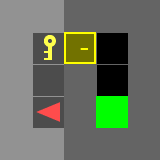


First, let's learn about how to interact with an env

**Question**: What do `env.reset()` and `env.step()` do? Why we need to call `env.reset()` before `env.step()`?  What is the input and output of `env.step()` and its meaning (i.e., meaning of `action`, `obs`, `reward`, `terminated`, `truncated`, `info`)? (Hint: You can refer to Gym environment [documentation](https://gymnasium.farama.org/api/env/) to understand how each function works.) **(10 pts)**

**A**: `env.reset()` is used to reset the state of the environment to the initial state and to start a new episode. `env.step()` is used to advance the state of the environment by one timestep. It applies the agent's action to the environment and advances the environment to the next state.

It's necessary to call `env.reset()` before `env.step()` to ensure that each new episode begins from a clean slate before the agent interacts with the environment and the environment's state changes. Upon resetting, the initial observation is returned which represents the state at the beginning of a new episode.

`env.step()` takes an action as input, which determines the action the agent should take given the current state of the environment. It returns a tuple of 5 elements, `obs`, `reward`, `terminated`, `truncated`, and `info`. `obs` is the new observation after the agent has executed the action, and `reward` is the corresponding reward for executing the action. `terminated` and `truncated` are boolean flags that indicate whether the episode has terminated (reached a natural terminal state of the environment - for instance the agent finds the key, opens the door, and goes to the green cell) or truncated (where the agent did not reach the natural terminate state -- either it exceeded the defined timesteps, or reached an unnatural terminal condition -- for instance when the humanoid falls when its learning to walk). `info` includes diagnostic or debug data that might be useful for analyzing the agent's performance or the environment's behavior (metrics, debug info).

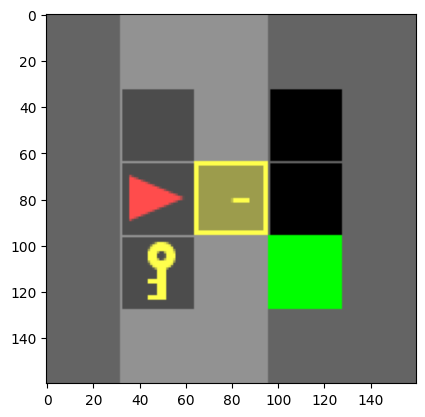

In [71]:
env = DoorKeyEnv5x5() # define environment.
env.reset()
action = env.action_space.sample()
obs, reward, terminated, truncated, info = env.step(action)

# get an RGB image corresponding to the whole environment or the agent's point of view (https://github.com/Farama-Foundation/Minigrid/blob/master/minigrid/minigrid_env.py#L716)
#            highlight (bool): If true, the agent's field of view or point of view is highlighted with a lighter gray color.
#            tile_size (int): How many pixels will form a tile from the NxM grid.
#            agent_pov (bool): If true, the rendered frame will only contain the point of view of the agent.
frame = env.get_frame(highlight=env.highlight, tile_size=env.tile_size, agent_pov=env.agent_pov)
# show an image to the notebook.
plt.imshow(frame)

# Model

Our *actor* will take in as input the `DoorKeyEnv5x5` observation (a 7x7x3 image), and output a categorical distribution over all possible actions.  To choose an action, we will sample from this distribution.  We suggest implementing the actor network to contain a few convolutional layers, followed by a few fully-connected layers.

In addition to the actor network, later questions in the PSET require estimating the value network, called the *critic*.  The critic estimates total future reward, but is notably *on-policy*, meaning it's reward estimates are conditioned on the actor. We will use the critic to reduce variance in the policy gradient estimate. We will get to that soon.

We have provided you a reference architecture to use for your actor-critic networks. Note that we have separate networks for each that do not share weights, as this has been shown to empirically improve performance. Also note that the policy outputs a `torch.distributions.categorical.Categorical` object.


In [8]:
class ACModel(nn.Module):
    def __init__(self, num_actions, use_critic=False): # what is num_actions
        """
        Represents an Actor Crictic model that takes a 2d, multi-channeled
        image as input.

        Parameters
        ----
        num_actions : int

                      The action space of the environment.
                      The action space for DoorKey5x5 is 7-dimensional:
                      0: turn left,
                      1: turn right,
                      2: forward,
                      3: pickup an object,
                      4: drop an object,
                      5: activate an object,
                      6: done completing task

        use_critics : bool

                      Critic network will be used in forward pass if flag is set
                      to true.
        """
        super().__init__()
        self.use_critic = use_critic

        # Define actor's model
        # Define CNN to process gym image
        self.image_conv_actor = nn.Sequential(
            nn.Conv2d(3, 16, (2, 2)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(16, 32, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(32, 64, (2, 2)),
            nn.ReLU()
        )
        # Take in output of actor CNN to output categorical distribution over
        # actions
        self.actor = nn.Sequential(
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, num_actions)
        )

        # Define critic's model
        if self.use_critic:
            # Define CNN to process gym image
            self.image_conv_critic = nn.Sequential(
                nn.Conv2d(3, 16, (2, 2)),
                nn.ReLU(),
                nn.MaxPool2d((2, 2)),
                nn.Conv2d(16, 32, (2, 2)),
                nn.ReLU(),
                nn.Conv2d(32, 64, (2, 2)),
                nn.ReLU()
            )
            # Take in output of critic CNN to output a value representing the
            # reward
            self.critic = nn.Sequential(
                nn.Linear(64, 64),
                nn.Tanh(),
                nn.Linear(64, 1)
            )

        # Initialize parameters correctly (don't remove this!)
        self.apply(init_params)

    def forward(self, obs):
        """
        Performs a forward pass through the actor-critic network

        Parameters
        ----
        obs : int tensor. Shape [Batch size, ImWidth, ImHeight, Channels]

              input to the network.
        ----

        returns:

        dist : torch.distribution
            The distribution of actions from policy. A Categorical distribution
            for discreet action spaces.
        value : torch.Tensor (Batch size, 1)
            value output by critic network
        """
        conv_in = obs.transpose(1, 3).transpose(2, 3) # reshape into expected order

        dist, value = None, None
        ##### produce Categorical action distribtuion and critic value output #####
        ##### if self.use_critic is false, return all zeros for value ###################
        x = self.image_conv_actor(conv_in)
        embedding = x.reshape(x.shape[0], -1)

        x = self.actor(embedding)
        dist = Categorical(logits=F.log_softmax(x, dim=1))

        if self.use_critic:
            y = self.image_conv_critic(conv_in)
            embedding = y.reshape(y.shape[0], -1)

            value = self.critic(embedding).squeeze(1)
        else:
            value = torch.zeros((x.shape[0], 1), device=x.device)
        ##################################################################################

        return dist, value

# Model Evaluation

The following code runs the actor critic model `acmodel` for one episode, and returns a dictionary with all the relevant information from the rollout.  It relies on placeholders below for `compute_advantage_gae` and `compute_discounted_return`: you can ignore these for now, and just evaluate through to the next section. Regarding `compute_advantage_gae`, the paper [Generalized Advantage Estimation](https://arxiv.org/abs/1506.02438) describes a nifty method for building a strong advantage estimate (see formula 16 in the paper) that empirically outperforms a naive subtraction (and includes reward shaping).

In [72]:
def compute_advantage_gae(values, rewards, T, gae_lambda, discount, device='cpu'):
    """
    Compute Adavantage wiht GAE. See Section 4.4.2 in the lecture notes.

    values: value at each timestep (T,)
    rewards: reward obtained at each timestep.  Shape: (T,)
    T: the number of frames, float
    gae_lambda: hyperparameter, float
    discount: discount factor, float

    -----

    returns:

    advantages : tensor.float. Shape [T,]

                 gae advantage term for timesteps 0 to T

    """
    advantages = torch.zeros_like(values).to(device)
    #### TODO: populate GAE in advantages over T timesteps (10 pts) ############
    deltas = (rewards[:-1] + discount * values[1:] - values[:-1]).to(device)

    T = len(deltas)
    gae_lambda_discount = gae_lambda * discount

    discounted_deltas_matrix = torch.zeros((T, T), device=device)

    for t in range(T):
        range_tensor = torch.arange(T - t, device=device)  # Create the range tensor on the same device
        discounted_deltas_matrix[t, t:] = deltas[t:] * (gae_lambda_discount ** range_tensor)

    advantages = torch.sum(discounted_deltas_matrix, dim=1)
    ############################################################################
    return advantages[:T]

#### Test GAE ####
checker_policy_gradient.test_general_advantage_estimation(compute_advantage_gae)

In [73]:
def compute_discounted_return(rewards, discount, device=None):
    """
		rewards: reward obtained at timestep.  Shape: (T,)
		discount: discount factor. float

    ----
    returns: sum of discounted rewards. Shape: (T,)
		"""
    returns = torch.zeros(*rewards.shape, device=device)
    #### TODO: populate discounted reward trajectory (10 pts) ############
    returns = torch.zeros(*rewards.shape, device=device)
    discounted_reward = 0
    for t in reversed(range(len(rewards))):
        discounted_reward = rewards[t] + discount * discounted_reward
        returns[t] = discounted_reward
    ######################################################################
    return returns

#### Test discounted return ####
checker_policy_gradient.test_compute_discounted_return(compute_discounted_return)

In [11]:
def collect_experiences(env, acmodel, args, device=None):
    """
    Collects rollouts and computes advantages.

    -------
    env     : DoorKeyEnv

              The environement used to execute policies in.


    acmodel : ACModel

              The model used to evaluate observations to collect experiences

    args    : Config

              config arguments


    device  : torch.cuda.device

              the device torch tensors are evaluated on.

    -------

    Returns
    -------
    exps : dict
        Contains actions, rewards, advantages etc as attributes.
        Each attribute, e.g. `exps['reward']` has a shape
        (self.num_frames, ...).
    logs : dict
        Useful stats about the training process, including the average
        reward, policy loss, value loss, etc.
    """


    MAX_FRAMES_PER_EP = 300
    shape = (MAX_FRAMES_PER_EP, )

    actions = torch.zeros(*shape, device=device, dtype=torch.int)
    values = torch.zeros(*shape, device=device)
    rewards = torch.zeros(*shape, device=device)
    log_probs = torch.zeros(*shape, device=device)
    obss = [None]*MAX_FRAMES_PER_EP

    obs, _ = env.reset()

    total_return = 0

    T = 0

    while True:
        # Do one agent-environment interaction

        preprocessed_obs = preprocess_obss(obs, device=device)

        with torch.no_grad():
            dist, value = acmodel(preprocessed_obs)
        action = dist.sample()[0]


        obss[T] = obs
        # update environment from taken action. We use the resulting observation,
        # reward, and whether or not environment is in the done/goal state.
        obs, reward, done, _, _ = env.step(action.item())


        # Update experiences values
        actions[T] = action
        values[T] = value
        rewards[T] = reward
        log_probs[T] = dist.log_prob(action)


        total_return += reward
        T += 1

        if done or T>=MAX_FRAMES_PER_EP-1:
            break

    discounted_reward = compute_discounted_return(rewards[:T], args.discount, device)

    # dict containing information on the experience
    exps = dict(
        obs = preprocess_obss([
            obss[i]
            for i in range(T)
        ], device=device),
        action = actions[:T],
        value  = values[:T],
        reward = rewards[:T],
        advantage = discounted_reward-values[:T],
        log_prob = log_probs[:T],
        discounted_reward = discounted_reward,
        advantage_gae=compute_advantage_gae(values, rewards, T, args.gae_lambda, args.discount, device=device)
    )

    logs = {
        "return_per_episode": total_return,
        "num_frames": T
    }

    return exps, logs

# REINFORCE

Now comes the fun part!  Using the `collect_experiences` function and `ACModel`, we will implement vanilla policy gradients.  The following function takes in an `optimizer`, `ACModel`, batch of experience `sb`, and some arguments `args` (see `Config` in setup for fields and default values), and should perform a policy gradients parameter update using the observed experience.

Fill in todos below to implement vanilla policy gradients **(20 pts)**.

In [74]:
def compute_policy_loss_reinforce(logps, returns):
    """
    Function for computing the policy loss for the REINFORCE algorithm. See
    4.2 of lecture notes.

		logps: log probabilities for each time step. Shape: (T,)
		returns: total return for each time step. Shape: (T,)

    ----
    return : tensor.float Shape: [T,]

             policy loss for each timestep
		"""
    policy_loss = torch.tensor(0)

    #### TODO: complete policy loss (10 pts) ###
    # HINT:  Recall, that we want to perform gradient ASCENT to maximize returns
    policy_loss = -(logps*returns).mean()
    ############################################

    return policy_loss

#### Test policy loss for REINFORCE algorithm ####
checker_policy_gradient.test_compute_policy_loss_reinforce(compute_policy_loss_reinforce)

In [75]:
def update_parameters_reinforce(optimizer, acmodel, sb, args):
    """
    optimizer: Optimizer function used to perform gradient updates to model. torch.optim.Optimizer
    acmodel: Network used to compute policy. torch.nn.Module
    sb: stores experience data. Refer to "collect_experiences". dict
    args: Config arguments. Config

    return output logs : dict
    """

    # logps is the log probability for taking an action for each time step. Shape (T,)
    logps, reward = None, None

    ### TODO: compute logps and reward from acmodel, sb['obs'], sb['action'], and sb['reward'] ###
    ### If args.use_discounted_reward is True, use sb['discounted_reward'] instead. ##############
    ### (10 pts) #########################################
    dist, value = acmodel(sb['obs'])
    logps = dist.log_prob(sb['action'])
    if args.use_discounted_reward:
      reward = sb['discounted_reward']
    else:
      reward = sb['reward']

    ##############################################################################################

    # computes policy loss
    policy_loss = compute_policy_loss_reinforce(logps, reward)
    update_policy_loss = policy_loss.item()

    # Update actor-critic
    optimizer.zero_grad()
    policy_loss.backward()

    # Perform gradient clipping for stability
    for p in acmodel.parameters():
        if p.grad is None:
            print("Make sure you're not instantiating any critic variables when the critic is not used")
    update_grad_norm = sum(p.grad.data.norm(2) ** 2 for p in acmodel.parameters()) ** 0.5
    torch.nn.utils.clip_grad_norm_(acmodel.parameters(), args.max_grad_norm)
    optimizer.step()

    # Log some values
    logs = {
        "policy_loss": update_policy_loss,
        "grad_norm": update_grad_norm
    }

    return logs

Now, let's try to run our implementation.  The following experiment harness is written for you, and will run sequential episodes of policy gradients until `args.max_episodes` timesteps are exceeded or the rolling average reward (over the last 100 episodes is greater than `args.score_threshold`. It is expected to get highly variable results, and we'll visualize some of this variability at the end.

The method accepts as arguments a `Config` object `args`, and a `parameter_update` method (such as `update_parameters_reinforce`).

In [14]:
def run_experiment(args, parameter_update, seed=0):
    """
    Upper level function for running experiments to analyze reinforce and
    policy gradient methods. Instantiates a model, collects epxeriences, and
    then updates the neccessary parameters.

    args: Config arguments. dict
    paramter_update: function used to update model parameters
    seed: random seed. int

    return: DataFrame indexed by episode
    """

    # Initialize random seeds for reproducible results
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    env = DoorKeyEnv5x5()

    acmodel = ACModel(env.action_space.n, use_critic=args.use_critic)
    acmodel.to(device)

    is_solved = False

    # Smooth reward taken from last SMOOTH_REWARD_WINDOW timesteps
    SMOOTH_REWARD_WINDOW = 50

    pd_logs, rewards = [], [0]*SMOOTH_REWARD_WINDOW

    optimizer = torch.optim.Adam(acmodel.parameters(), lr=args.lr)
    num_frames = 0

    pbar = tqdm(range(args.max_episodes)) # show progess bar ()
    for update in pbar:
        # First collect experiences
        exps, logs1 = collect_experiences(env, acmodel, args, device)
        # update parameters from experiences
        logs2 = parameter_update(optimizer, acmodel, exps, args)

        logs = {**logs1, **logs2}

        num_frames += logs["num_frames"]

        rewards.append(logs["return_per_episode"])

        smooth_reward = np.mean(rewards[-SMOOTH_REWARD_WINDOW:])

        data = {'episode':update, 'num_frames':num_frames, 'smooth_reward':smooth_reward,
                'reward':logs["return_per_episode"], 'policy_loss':logs["policy_loss"]}

        if args.use_critic:
            data['value_loss'] = logs["value_loss"]

        pd_logs.append(data)

#         pbar.set_postfix(data)

        # Early terminate
        if smooth_reward >= args.score_threshold:
            is_solved = True
            break

    if is_solved:
        print('Solved!')

    return pd.DataFrame(pd_logs).set_index('episode')


## Run Reinforce

Great!  Now let's run our implementation, and see how we do.

100%|██████████| 2000/2000 [19:30<00:00,  1.71it/s]


<Axes: xlabel='num_frames'>

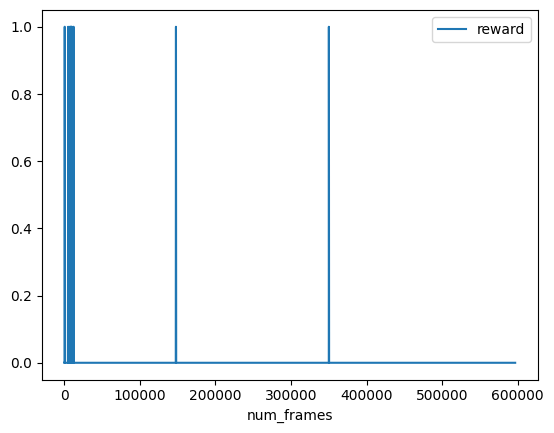

In [74]:
args = Config()
df = run_experiment(args, update_parameters_reinforce)

df.plot(x='num_frames', y='reward')

## REINFORCE with Discounted Reward

Uh oh! Even after 300,000 steps, our policy does not converge. One reason for failure is the way rewards are generated in the real-world. In an ideal world, the agent would be rewarded at every timestep in a manner that perfectly corresponded to the quality of the action taken in a particular state.  However, this is rarely the case; for example, in Doorkey we only get reward at the very end of the episode (i.e., the sparse reward scenario).

Oh, the reward is binary and difficult to see the improvement since it depends on the density of the blue bar in the plot. So, we smooth reward by averaging certain amount of rewards from previous episode (`smooth_reward`).

Fill in `compute_discounted_return` code block above, then run code cell below to see the effect of discounted reward trajectories.  This should converge, so if it doesn't, you've made an error (although try re-running the cell a few times first to make sure it's not a bad random seed). **(10 pts)**



 71%|███████   | 1412/2000 [10:06<04:12,  2.33it/s]

Solved!


<Axes: xlabel='num_frames'>

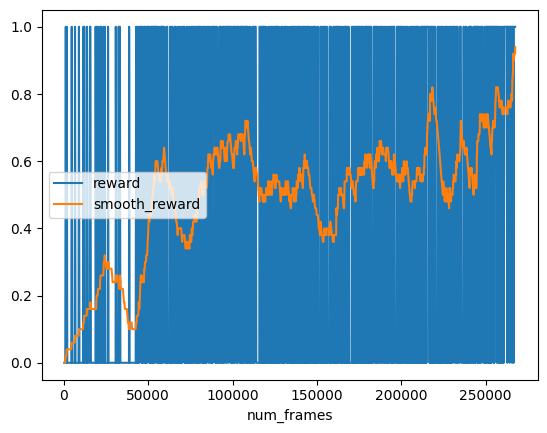

In [34]:
args = Config(use_discounted_reward=True)
df = run_experiment(args, update_parameters_reinforce)

df.plot(x='num_frames', y=['reward', 'smooth_reward'])

# Vanilla Policy Gradients

You may have noticed that the REINFORCE training curve is extremely unstable. It's time to bring in our *critic*!  We can prove from the Expected Grad-Log-Prob (EGLP) lemma that we can subtract any function $b(x)$ from our reward without changing our policy in expectation:

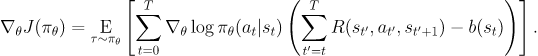

### Baseline Proof

**Question**: Prove that adding a baseline doesn't change the policy in expectation using the EGLP lemma. **(10 pts)**

**EGLP lemma** Suppose that $P_{\theta}$ is a parameterized probability distribution over a random variable, $x$. Then:

$E_{x \sim P_{\theta}}{ [ \nabla_{\theta} \log P_{\theta}(x) ] } = 0$.

**Proof**: Please find it at the end of this PDF. (Appended as PDF)

Empirically, using the on-policy value function as the baseline ($b$) reduces variance in the policy gradient sample estimate, leading to faster and more stable learning.  We can estimate the $b$ using an L2 loss to the true rewards (or in our case, the discounted rewards), and constitutes an additional loss term in the overall objective. The baseline substracted return term, $R(s_{t'},a_{t'},s_{t' + 1}) - b(s_t)$ is already computed for you, and is referred to as the *advantage*.

In [15]:
def compute_policy_loss_with_baseline(logps, advantages):
    """
    Computes policy loss with added baseline term. Refer to 4.3 in Lecture Notes.
    logps:  computed log probabilities. shape (T,)
    advantages: computed advantages. shape: (T,)

    ---

    return policy loss computed with baseline term: tensor.float. Shape (,1)

           refer to 4.3- Baseline in lecture notes

    """
    policy_loss = 0

    ### TODO: implement the policy loss (5 pts) ##############
    # print(f'shape of logps : {logps.shape}, shape of advantages : {advantages.shape}')
    policy_loss = -torch.mean(logps*advantages[:len(logps)])

    ##################################################

    return policy_loss

#### Test discounted return ####
checker_policy_gradient.test_compute_policy_loss_with_baseline(compute_policy_loss_with_baseline)

In [76]:
def update_parameters_with_baseline(optimizer, acmodel, sb, args):
    """
    Updates model parameters using value and policy functions

    optimizer: Optimizer function used to perform gradient updates to model. torch.optim.Optimizer
    acmodel: Network used to compute policy. torch.nn.Module
    sb: stores experience data. Refer to "collect_experiences". dict
    args: Config arguments
    """
    def _compute_value_loss(values, returns):
        """
        Computes the value loss of critic model. See 4.3 of Lecture Notes

        values: computed values from critic model shape: (T,)
        returns: discounted rewards. shape: (T,)


        ---
        computes loss of value function. See 4.3, eq. 11 in lecture notes : tensor.float. Shape (,1)
        """

        value_loss = 0

        ### TODO: implement the value loss (5 pts) ###############
        value_loss = F.mse_loss(values, returns)
        ##################################################

        return value_loss

    logps, advantage, values, reward = None, None, None, None

    dist, values = acmodel(sb['obs'])
    logps = dist.log_prob(sb['action'])
    advantage = sb['advantage_gae'] if args.use_gae else sb['advantage']
    reward = sb['discounted_reward']

    policy_loss = compute_policy_loss_with_baseline(logps, advantage)
    value_loss = _compute_value_loss(values, reward)
    loss = policy_loss + value_loss

    update_policy_loss = policy_loss.item()
    update_value_loss = value_loss.item()

    # Update actor-critic
    optimizer.zero_grad()
    loss.backward()
    update_grad_norm = sum(p.grad.data.norm(2) ** 2 for p in acmodel.parameters()) ** 0.5
    torch.nn.utils.clip_grad_norm_(acmodel.parameters(), args.max_grad_norm)
    optimizer.step()

    # Log some values

    logs = {
        "policy_loss": update_policy_loss,
        "value_loss": update_value_loss,
        "grad_norm": update_grad_norm
    }

    return logs

## Run REINFORCE with baseline

If you did everything right, you should be able to run the below cell to run the vanilla policy gradients implementation with baseline.  This should be somewhat more stable than without the baseline, and likely converge faster.


 39%|███▉      | 785/2000 [07:43<11:58,  1.69it/s]

Solved!


<Axes: xlabel='num_frames'>

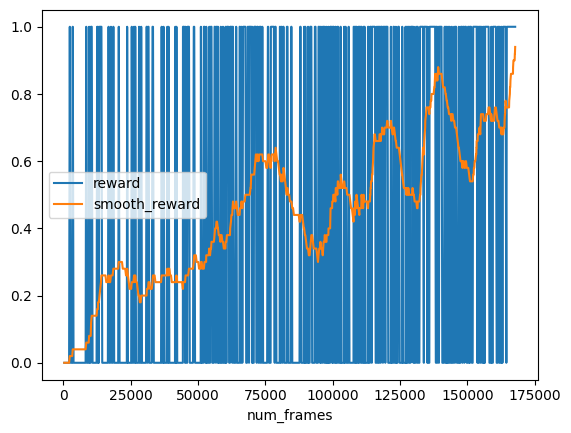

In [29]:
args = Config(use_critic=True)
df_baseline = run_experiment(args, update_parameters_with_baseline)

df_baseline.plot(x='num_frames', y=['reward', 'smooth_reward'])

# Reinforce with GAE

The advantage we computed above seemed to work, and hopefully improved our results! Fortunately, we can do even better. The paper Generalized Advantage Estimation describes a nifty method for building a strong advantage estimate (see formula 16 in the paper) that empirically outperforms a naive subtraction (and includes reward shaping). Implemented the GAE function we left blank from earlier.

 19%|█▉        | 388/2000 [03:16<13:35,  1.98it/s]

Solved!


<Axes: xlabel='num_frames'>

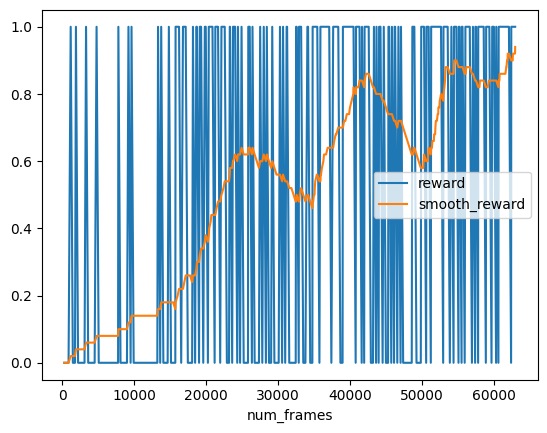

In [66]:
args = Config(use_critic=True, use_gae=True)
df_gae = run_experiment(args, update_parameters_with_baseline)

df_gae.plot(x='num_frames', y=['reward', 'smooth_reward'])

# Fancy Plots
If you've gotten to this point, congrats: you've succesfully implemented REINFORCE, VPG, and GAE!

**(10 pts)** Now let's visualize every result in one plot.

<Axes: xlabel='num_frames'>

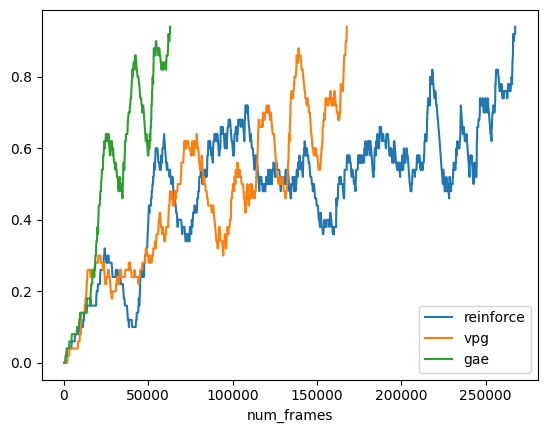

In [77]:
# TODO Visualize all results into one plot.
df_baseline1 = df_baseline.rename(columns={'smooth_reward':'vpg'})
df_1 = df.rename(columns={'smooth_reward': 'reinforce'})
df_gae1 = df_gae.rename(columns={'smooth_reward': 'gae'})

combined = pd.concat([df_baseline1, df_1, df_gae1])
combined.plot(x='num_frames', y=['reinforce', 'vpg', 'gae'])


While we've been able to anecdotally compare their performance, we don't have any sense of *scientific rigor*.  Notably, given the variance you've likely seen between runs of these models, a single run may not reflect how strong a model really is.

**(10 pts)** Compare the performance between the different methods in below plot. What is the best performing method? How is variance reflected in these plots? What could account for this variance?

**A**

From the plot, it appears that reinforce improves rapidly initially, but then its performance starts to deteriorate. VPG improves consistently, and gae performs close to reinforce with its performance deteriorating at the end. From the graph, it appears that vpg is the best performing method.

The shaded region represents the variance for each of the methods. From the graph, it appears that gae exhibits very high variance (as seen by its shaded area), and its average performance (computed over multiple runs) is lower than the other two methods. Compared to gae, both vpg and reinforce have lower variance.

Although, GAE is expected to exhibit lower variance than the other two methods because of its usage of advantage estimates, it could exhibit higher variance due to choice of lambda parameter (which is used to balance bias variance tradeoff). It could also be because of biases during the bootstrapping process, especially when the bootstrapped estimates are noisy. Another reason could be that TD errors (difference between predicted and observed rewards) could be noisy leading to high variance.  

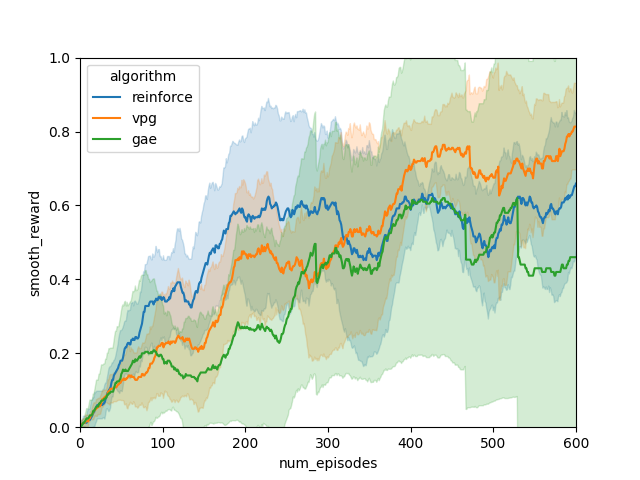

# Survey (bonus points, 10 pts)
Please fill out [this anonymous survey](https://forms.gle/s5YnyTmeF7UnXuKy7) and enter the code below to receive credit. Thanks!

**Code:** policy_gradient